In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from params import *
import tqdm
import ghibtools as gh
import seaborn as sns
import pingouin as pg
from pycircstat import watson_williams
%matplotlib inline

## PARAMS

In [105]:
savefig = False

## TOOLS

In [4]:
def load_resp(patient):
    rsp = pd.read_excel(f'../df_analyse/resp_features_{patient}.xlsx', index_col = 0)
    return rsp

In [5]:
def load_sp(patient):
    spindles = pd.read_excel(f'../df_analyse/spindles_{patient}.xlsx', index_col = 0)
    return spindles

In [6]:
def load_sw(patient):
    sw = pd.read_excel(f'../df_analyse/sw_{patient}.xlsx', index_col = 0)
    return sw

In [7]:
def get_timestamps(df_cycles, spindles_times, patient):
    rows = []

    for cycle in df_cycles.index: # loop only on cycles with spindles found inside

        start = df_cycles.loc[cycle,'inspi_time'] # get start time of the cycle
        transition = df_cycles.loc[cycle,'expi_time'] # get i-e time of the cycle
        stop = start + df_cycles.loc[cycle,'cycle_duration'] # get stop time of the cycle
        duration = df_cycles.loc[cycle,'cycle_duration']
        inspi_duration = transition - start
        expi_duration = stop - transition

        spindles_of_the_cycle = spindles_times[(spindles_times >= start) & (spindles_times <= stop)].values # keep the spindles of the cycle

        for spindle_time in spindles_of_the_cycle: # loop on spindles of the cycle
            time_post_start = spindle_time - start
            time_vs_transition = spindle_time - transition
            time_pre_end = stop - spindle_time

            norm_time = (spindle_time - start) / duration
            angle = norm_time * 2*np.pi

            rows.append([patient, cycle, start, transition, stop, inspi_duration, expi_duration, duration, spindle_time, time_post_start, time_vs_transition, time_pre_end, norm_time, angle])
    df_times = pd.DataFrame(rows, columns = ['patient','cycle','start cycle', 'transition ie', 'stop cycle', 'inspi duration','expi duration','cycle duration','spindle time', 'time post start', 'time vs transition ie','time pre end','norm time','angle'])
    return df_times

In [8]:
def get_circ_features(angles):
    z, pval = pg.circ_rayleigh(angles)
    mu = pg.circ_mean(angles) #+ np.pi
    mu = np.degrees(mu)
    r = pg.circ_r(angles)
    if mu < 0:
        mu = 360 + mu
    return pval, mu, r

In [9]:
def get_angles(event_kind, patients=patients):
    concat_df_times = []

    for patient in patients:
        if event_kind == 'sw':
            df_cycles, spindles_times = load_resp(patient), load_sw(patient)['NegPeak']
        elif event_kind == 'sp':
            df_cycles, spindles_times = load_resp(patient), load_sp(patient)['Peak']
        concat_df_times.append(get_timestamps(df_cycles, spindles_times, patient))

    df_times_all = pd.concat(concat_df_times)
    return df_times_all.loc[:,['patient','angle']]

In [10]:
sp_angles = get_angles('sp')
sw_angles = get_angles('sw')

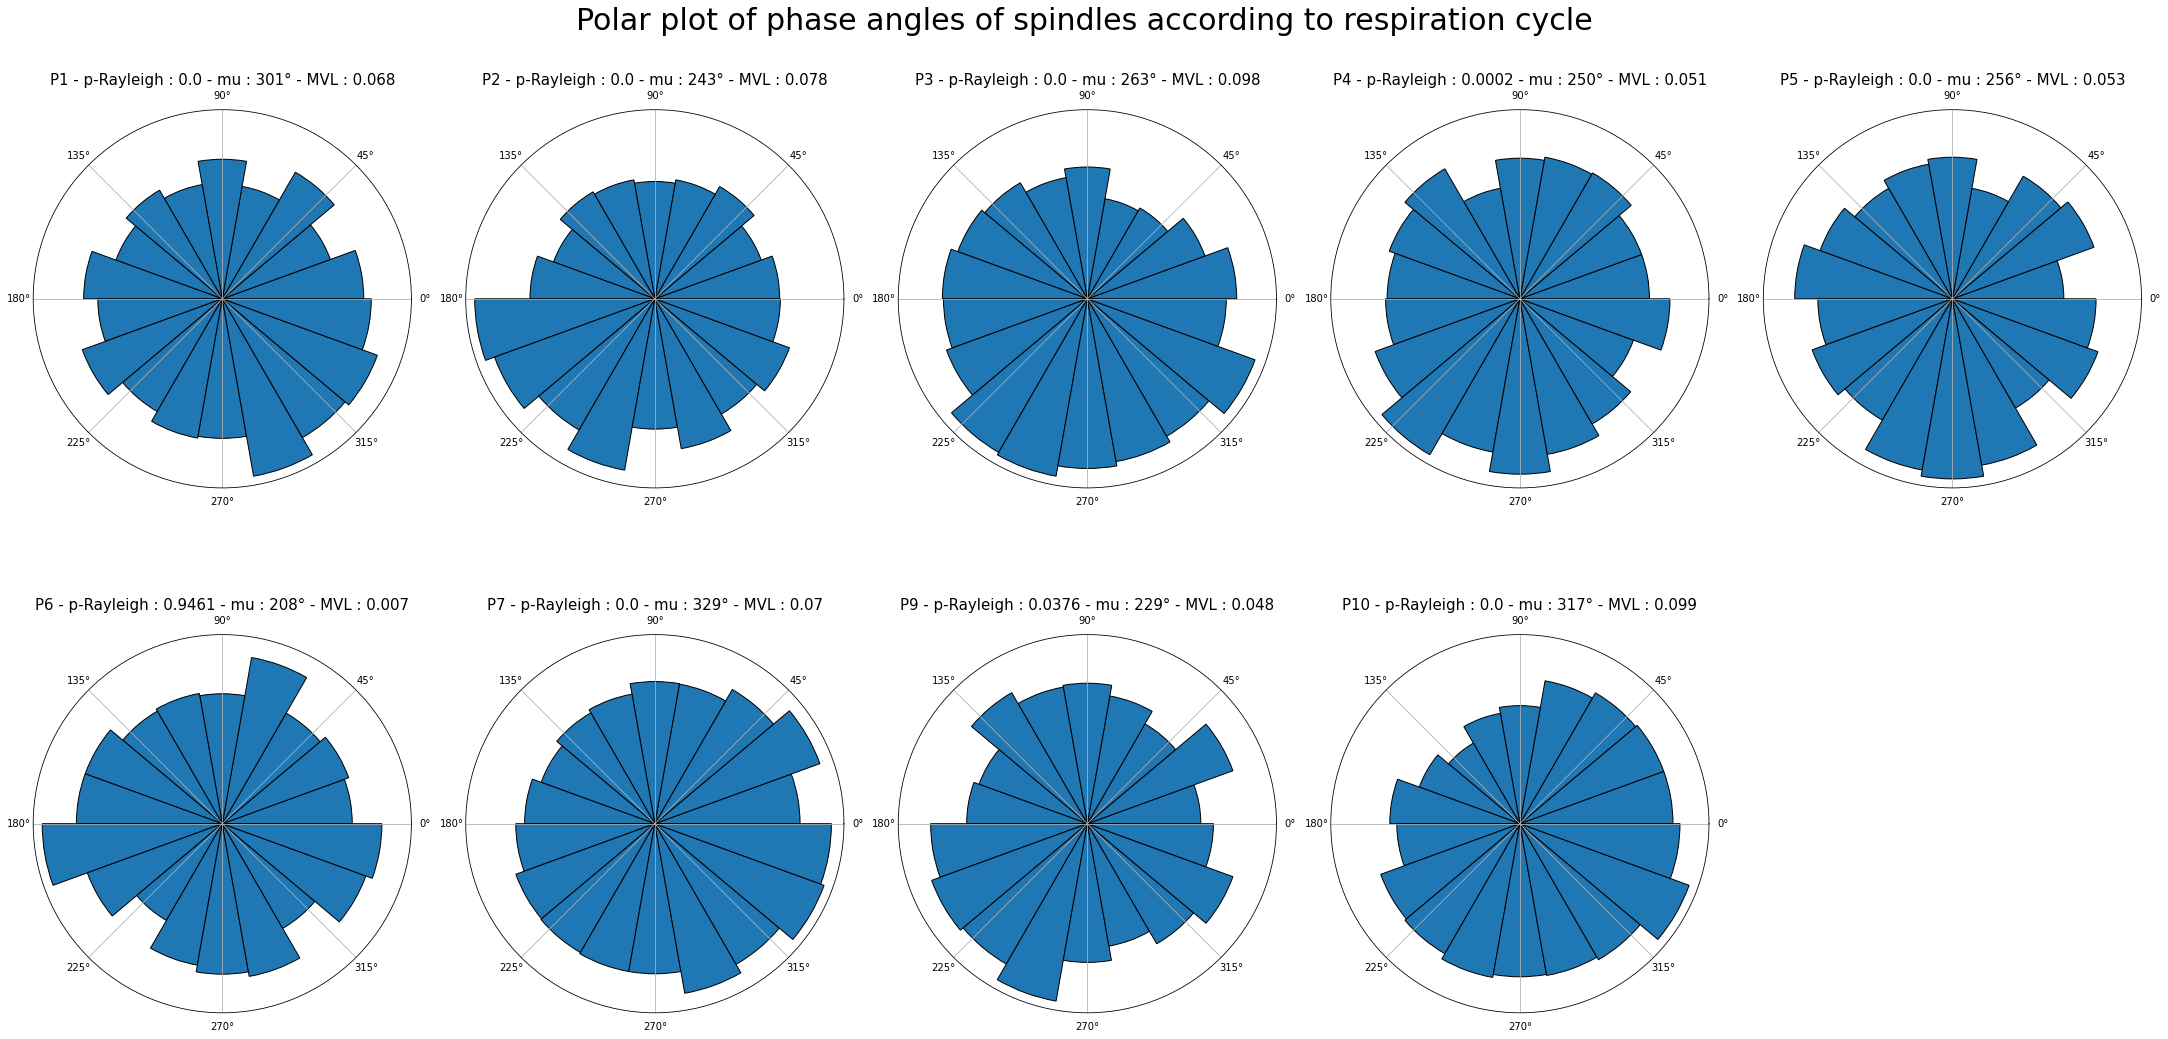

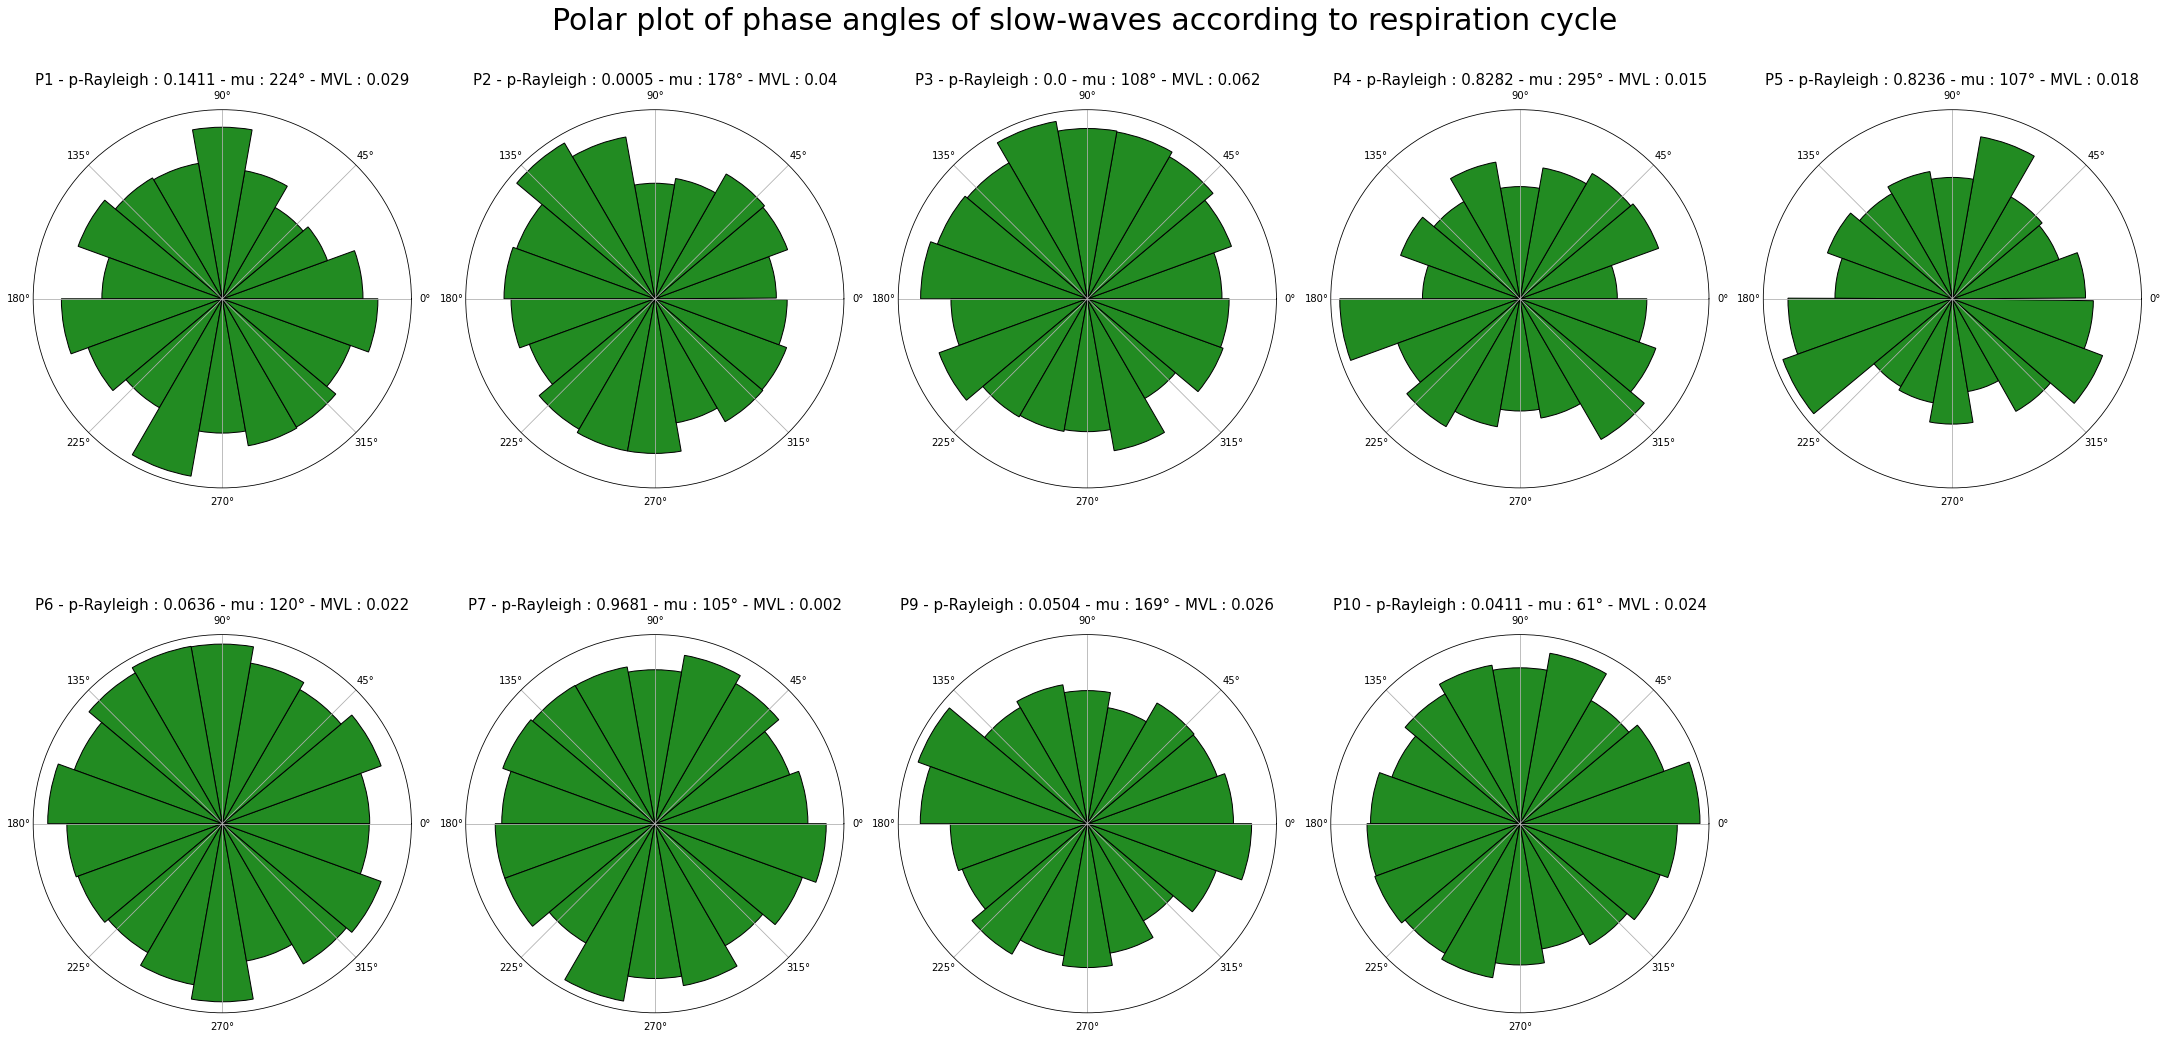

In [11]:
for event_kind in ['spindles','slow-waves']:
    
    if event_kind == 'spindles':
        angles_events = sp_angles
        color = None
    elif event_kind == 'slow-waves':
        angles_events = sw_angles
        color = 'forestgreen'
  
    fig, axs = plt.subplots(nrows = 2, ncols = 5, subplot_kw=dict(projection = 'polar'), figsize = (30,15), constrained_layout = True)
    fig.suptitle(f'Polar plot of phase angles of {event_kind} according to respiration cycle', fontsize = 30)
    bins = 18
    for row, sublist in enumerate([ patients[:5], patients[5:]]):
        for col, patient in enumerate(sublist):
            ax = axs[row, col]
            angles = angles_events[angles_events['patient'] == patient]['angle']
            p, mu , r = get_circ_features(angles)
            ax.hist(angles, bins = bins, density = True, edgecolor = 'black', color = color)
            ax.set_rticks([])
            ax.set_title(f'{patient} - p-Rayleigh : {round(p, 4)} - mu : {int(mu)}° - MVL : {round(r, 3)}', fontsize = 15, y = 1.05)
    fig.delaxes(axs[1,4])
    if savefig:
        plt.savefig(f'../presentation_5/detailed_polar_plot_{event_kind}', bbox_inches = 'tight')

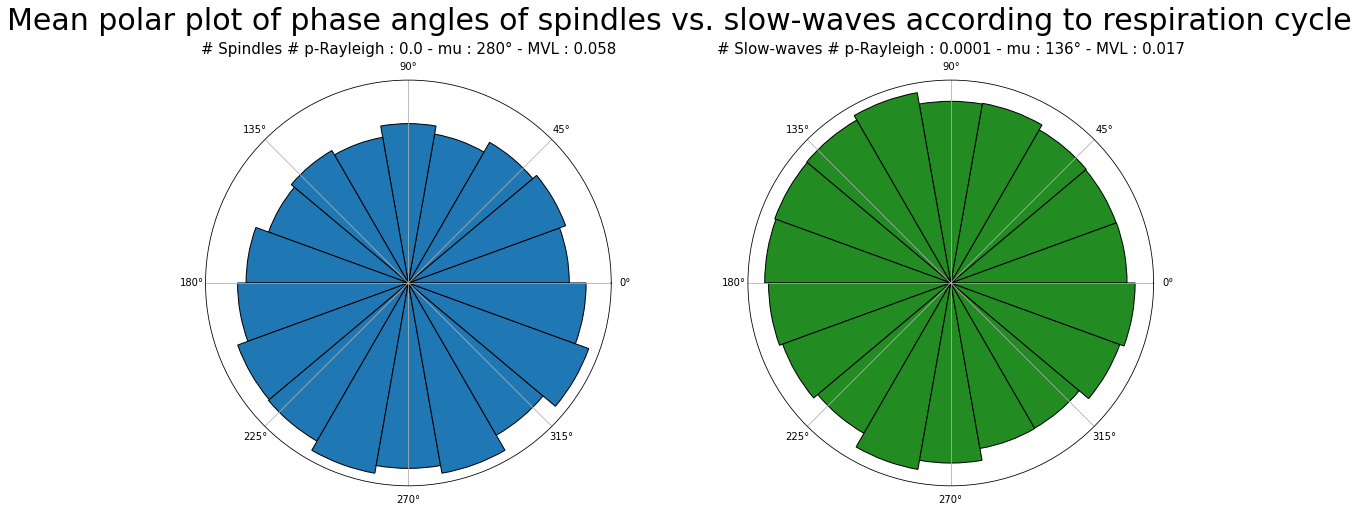

In [12]:
fig, axs = plt.subplots(ncols = 2, subplot_kw=dict(projection = 'polar'), figsize = (15,7), constrained_layout = True)
fig.suptitle(f'Mean polar plot of phase angles of spindles vs. slow-waves according to respiration cycle', fontsize = 30)
bins = 18

for col, event_kind in enumerate(['Spindles','Slow-waves']):
    if event_kind == 'Spindles':
        angles_events = sp_angles
        color = None
    elif event_kind == 'Slow-waves':
        angles_events = sw_angles
        color = 'forestgreen'      
    
    ax = axs[col]
    angles = angles_events['angle']
    p, mu , r = get_circ_features(angles)
    ax.hist(angles, bins = bins, density = False, edgecolor = 'black', color = color)
    ax.set_rticks([])
    ax.set_title(f'# {event_kind} # p-Rayleigh : {round(p, 4)} - mu : {int(mu)}° - MVL : {round(r, 3)}', fontsize = 15, y = 1.05)
if savefig:
    plt.savefig('../presentation_5/mean_polar_plot', bbox_inches = 'tight')

/home/valentin.ghibaudo/.virtualenvs/py38_cluster/lib64/python3.8/site-packages/pycircstat/tests.py:416: UserWarning: Test not applicable. Average resultant vector length < 0.45.
  warnings.warn(


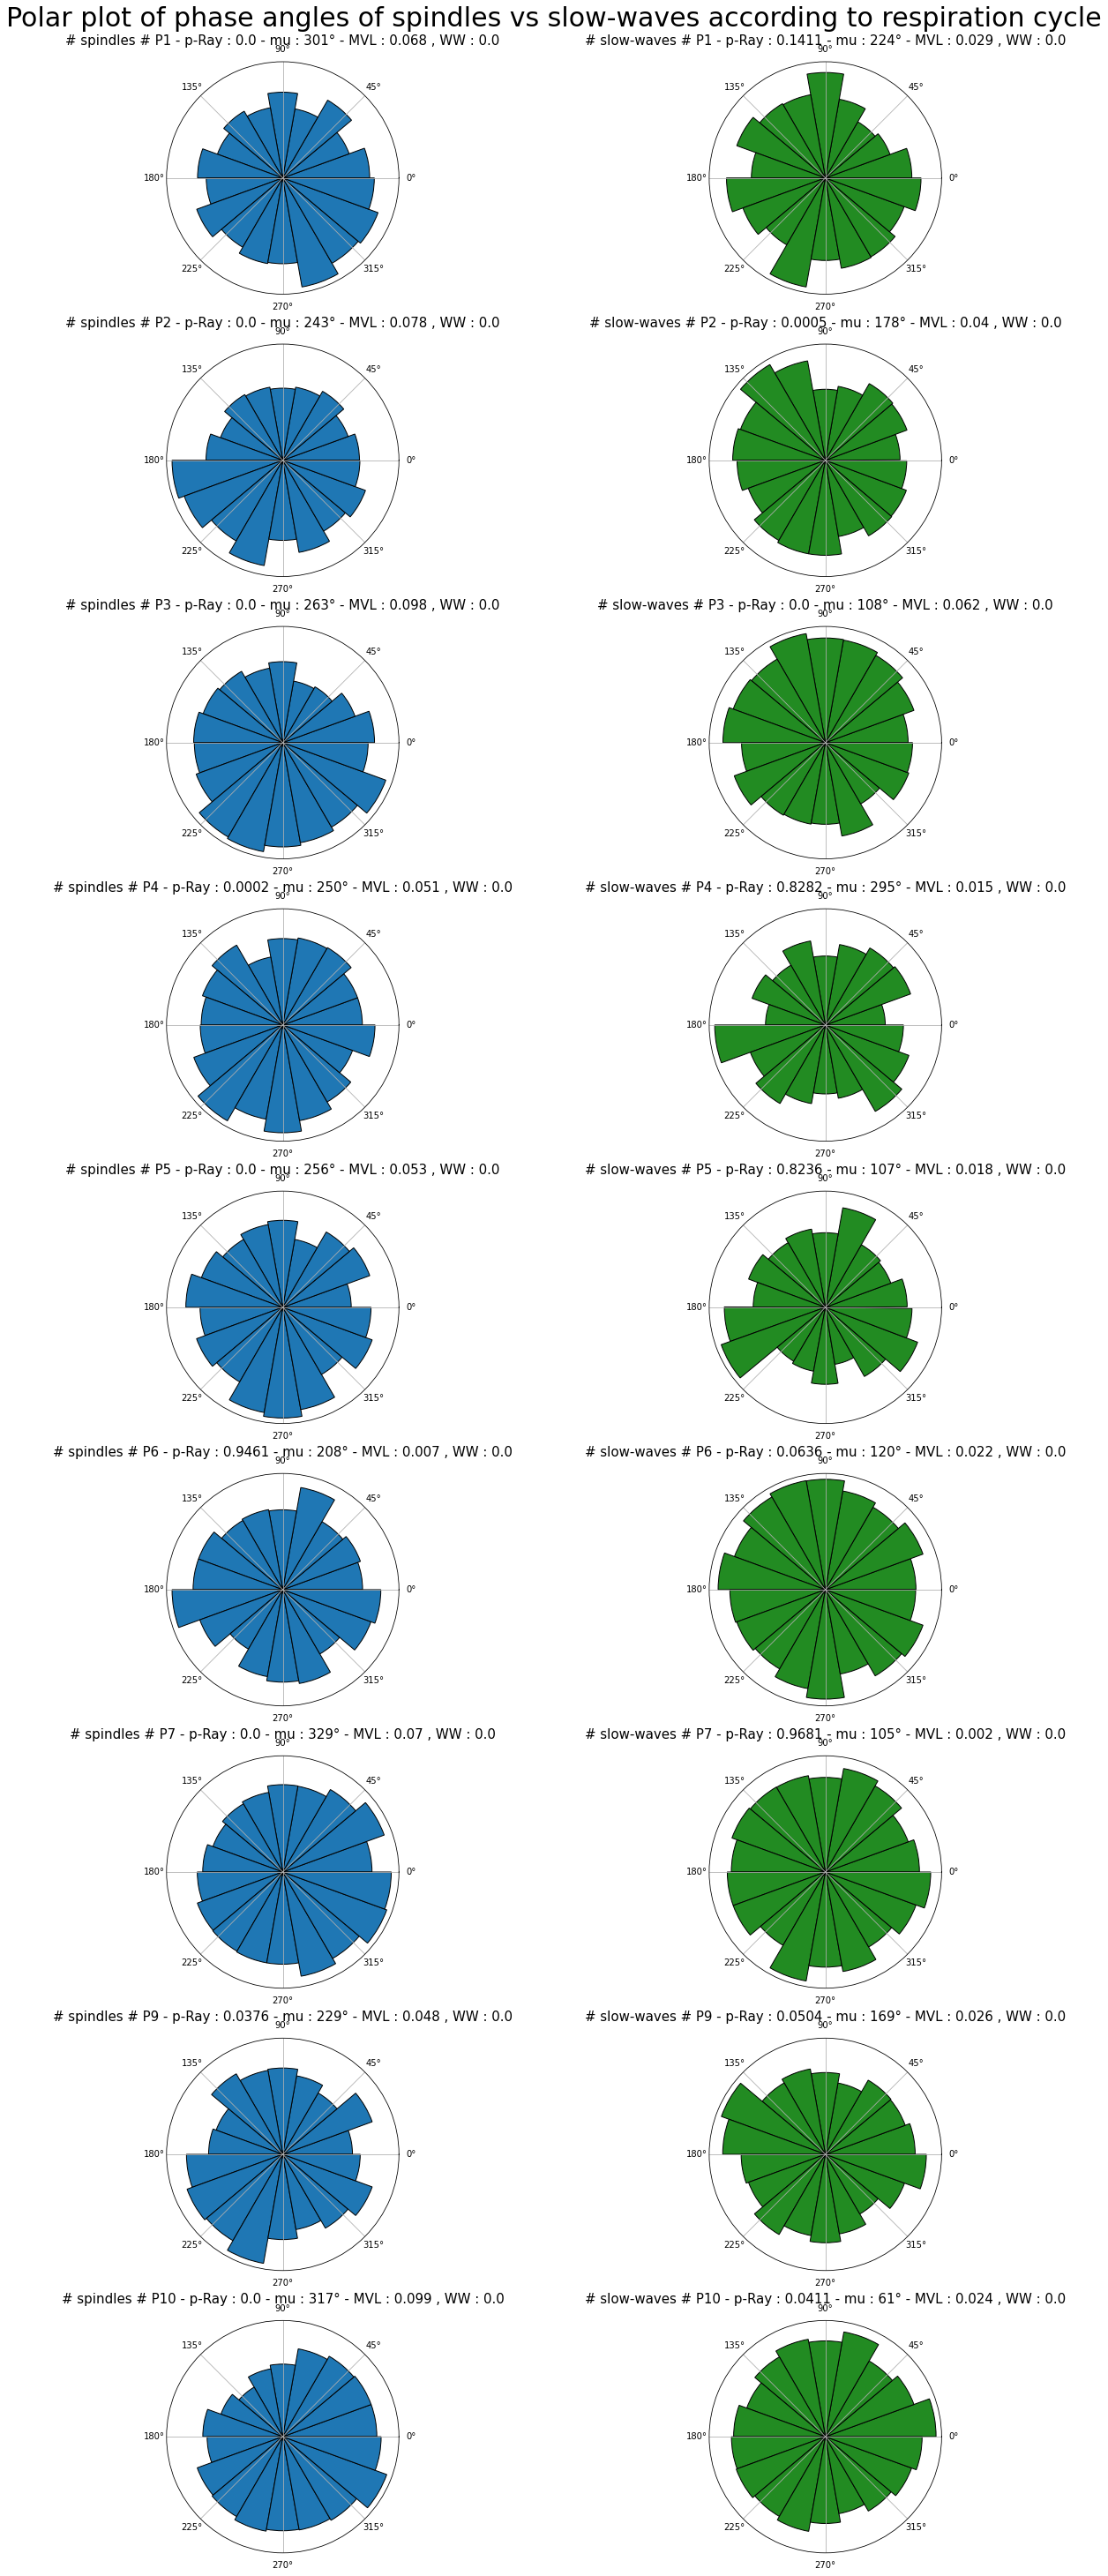

In [13]:
fig, axs = plt.subplots(nrows = len(patients), ncols = 2, subplot_kw=dict(projection = 'polar'), figsize = (17,40), constrained_layout = True)
fig.suptitle(f'Polar plot of phase angles of spindles vs slow-waves according to respiration cycle', fontsize = 30, y = 1.01)
bins = 18
for row, patient in enumerate(patients): 
    sp_angles_patient = sp_angles[sp_angles['patient'] == patient]['angle']
    sw_angles_patient = sw_angles[sw_angles['patient'] == patient]['angle']
    
    p_ww, T = watson_williams(sp_angles_patient, sw_angles_patient)
    
    for col, event_kind in enumerate(['spindles','slow-waves']):
        if event_kind == 'spindles':
            angles_events = sp_angles_patient
            color = None
        elif event_kind == 'slow-waves':
            angles_events = sw_angles_patient
            color = 'forestgreen'

        ax = axs[row, col]
        p, mu , r = get_circ_features(angles_events)
        ax.hist(angles_events, bins = bins, density = True, edgecolor = 'black', color = color)
        ax.set_rticks([])
        ax.set_title(f'# {event_kind} # {patient} - p-Ray : {round(p, 4)} - mu : {int(mu)}° - MVL : {round(r, 3)} , WW : {round(p_ww, 4)}', fontsize = 15, y = 1.05)
if savefig:
    plt.savefig('../presentation_5/detailed_polar_plot_williams', bbox_inches = 'tight')

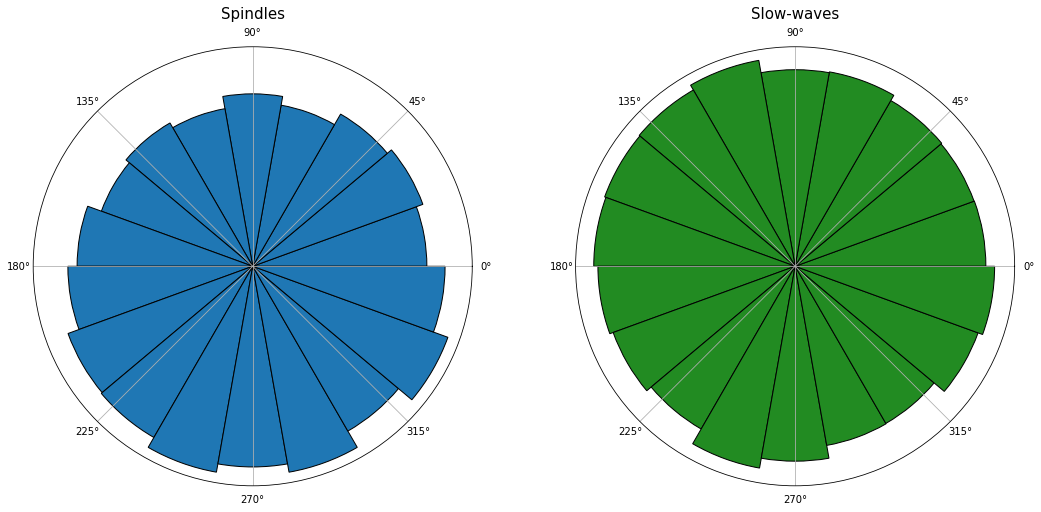

In [14]:
fig, axs = plt.subplots(ncols = 2, subplot_kw=dict(projection = 'polar'), figsize = (15,7), constrained_layout = True)
bins = 18

for col, event_kind in enumerate(['Spindles','Slow-waves']):
    if event_kind == 'Spindles':
        angles_events = sp_angles
        color = None
    elif event_kind == 'Slow-waves':
        angles_events = sw_angles
        color = 'forestgreen'      
    
    ax = axs[col]
    angles = angles_events['angle']
    p, mu , r = get_circ_features(angles)
    ax.hist(angles, bins = bins, density = False, edgecolor = 'black', color = color)
    ax.set_rticks([])
    ax.set_title(event_kind, fontsize = 15, y = 1.05)
if savefig:
    plt.savefig('../article/mean_polar_plot', bbox_inches = 'tight')

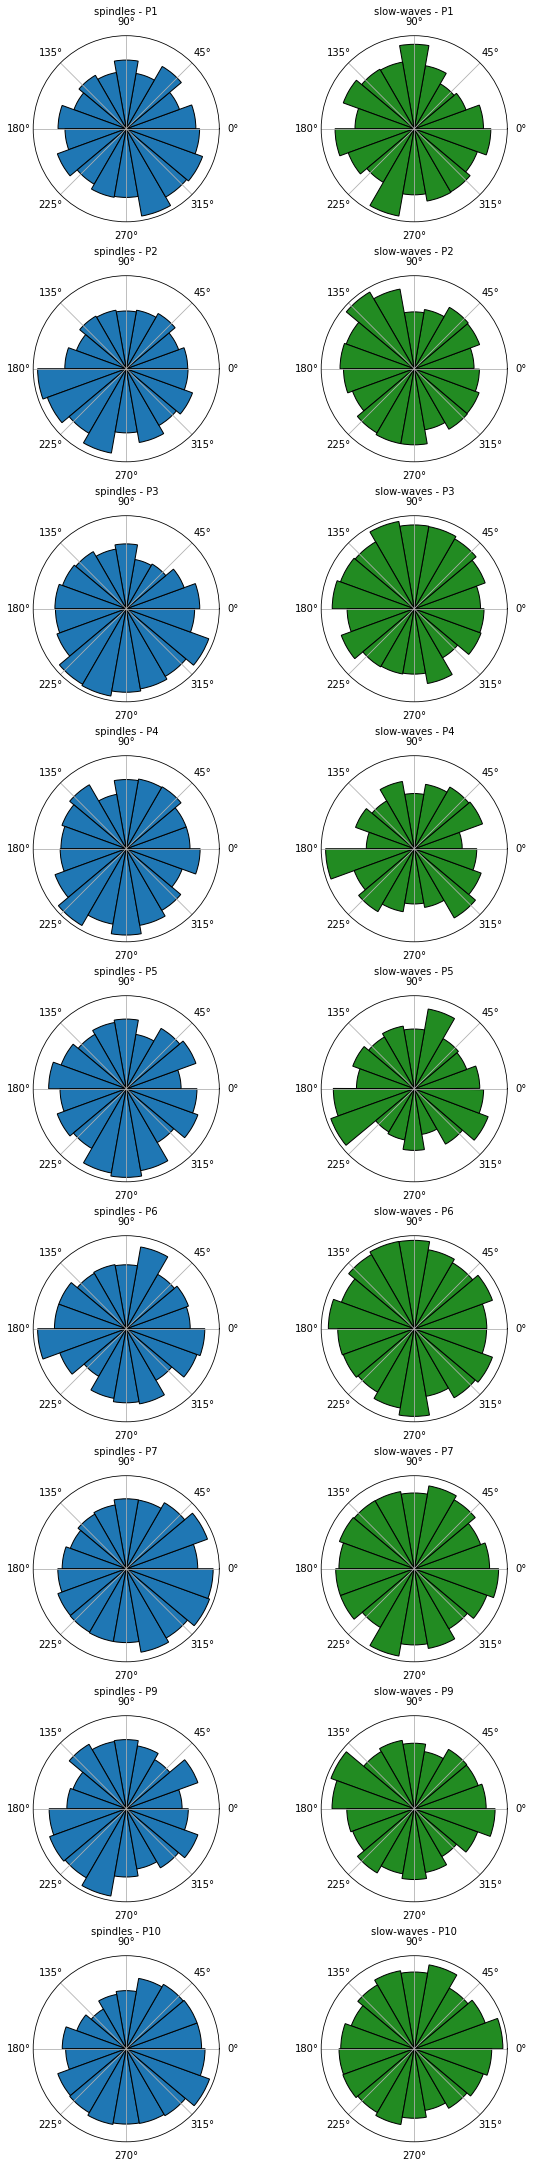

In [16]:
fig, axs = plt.subplots(nrows = len(patients), ncols = 2, subplot_kw=dict(projection = 'polar'), figsize = (8,30), constrained_layout = True)
bins = 18
for row, patient in enumerate(patients): 
    sp_angles_patient = sp_angles[sp_angles['patient'] == patient]['angle']
    sw_angles_patient = sw_angles[sw_angles['patient'] == patient]['angle']
    
    p_ww, T = watson_williams(sp_angles_patient, sw_angles_patient)
    
    for col, event_kind in enumerate(['spindles','slow-waves']):
        if event_kind == 'spindles':
            angles_events = sp_angles_patient
            color = None
        elif event_kind == 'slow-waves':
            angles_events = sw_angles_patient
            color = 'forestgreen'

        ax = axs[row, col]
        p, mu , r = get_circ_features(angles_events)
        ax.hist(angles_events, bins = bins, density = True, edgecolor = 'black', color = color)
        ax.set_rticks([])
        ax.set_title(f'{event_kind} - {patient}', fontsize = 10, y = 1.08)
if savefig:
    plt.savefig('../article/detailed_polar_plot', bbox_inches = 'tight')

In [17]:
rows = []

for event_kind in ['Spindles','Slow-waves']:
    if event_kind == 'Spindles':
        angles_events = sp_angles
    elif event_kind == 'Slow-waves':
        angles_events = sw_angles
    
    for participant in patients:
        angles = angles_events[angles_events['patient'] == participant]['angle']
        p, mu , r = get_circ_features(angles)
        
        if p > 0.05:
            stars = 'ns'
        elif p < 0.05 and p >= 0.01:
            stars = '*'
        elif p < 0.01 and p >= 0.001:
            stars = '**'
        elif p < 0.001:
            stars = '***'
        
        row = [participant, event_kind , p, stars, int(mu) , round(r, 3)]
        rows.append(row)
stats_table = pd.DataFrame(rows, columns = ['Participant', 'Event','p-Rayleigh', 'Rayleigh Significance', 'Mean Direction (°)','Mean Vector Length'])   
if savefig:
    stats_table.to_excel('../article/stats_table.xlsx')

In [20]:
stats_table

,Participant,Event,p-Rayleigh,Rayleigh Significance,Mean Direction (°),Mean Vector Length
0,P1,Spindles,5.266935e-06,***,301,0.068
1,P2,Spindles,2.922755e-10,***,243,0.078
2,P3,Spindles,1.396908e-20,***,263,0.098
3,P4,Spindles,2.171709e-04,***,250,0.051
4,P5,Spindles,3.400666e-05,***,256,0.053
5,P6,Spindles,9.461129e-01,ns,208,0.007
6,P7,Spindles,8.194756e-14,***,329,0.070
7,P9,Spindles,3.757807e-02,*,229,0.048
8,P10,Spindles,1.706195e-11,***,317,0.099
9,P1,Slow-waves,1.411373e-01,ns,224,0.029


In [101]:
rows = []
for participant in patients:
    sp_angles_participant = sp_angles[sp_angles['patient'] == participant]['angle'].values
    bin_values , x = np.histogram(sp_angles_participant, bins = 2)
    norm_bin_values = bin_values / sum(bin_values)
    norm_bin_values = np.round(norm_bin_values, 3)
    rows.append([participant, 'first half', norm_bin_values[0]])
    rows.append([participant, 'second half', norm_bin_values[1]])
bins_2 = pd.DataFrame(rows, columns = ['participant', 'half', 'count'])

<BarContainer object of 9 artists>
<BarContainer object of 9 artists>


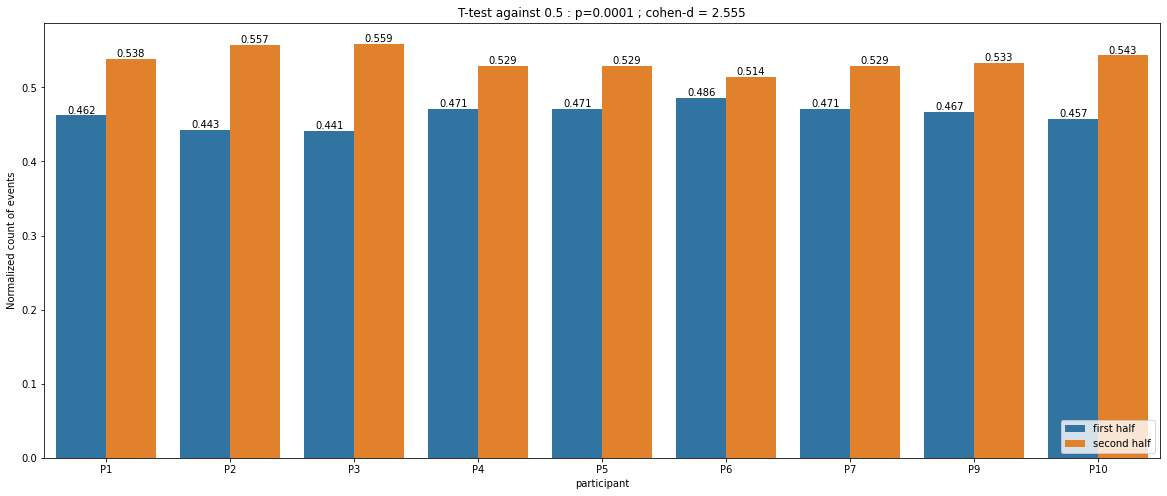

In [104]:
fig, ax = plt.subplots(figsize = (20,8))
sns.barplot(data=bins_2, x = 'participant', hue = 'half', y = 'count', ax=ax)
ax.set_ylabel('Normalized count of events')
ax.legend(loc = 4)
ttest = pg.ttest(x= bins_2[bins_2['half']=='second half']['count'] , y= 0.5)
p = ttest.loc['T-test', 'p-val'].round(4)
cohen = ttest.loc['T-test', 'cohen-d'].round(4)
ax.set_title(f'T-test against 0.5 : p={p} ; cohen-d = {cohen}')
for i in ax.containers:
    print(i)
    ax.bar_label(i,)
    
if savefig: 
    plt.savefig('../article/2_bins')